In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys


# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.circuit.library.standard_gates import SXGate, SXdgGate
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator, Pauli
import math
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import MCMT
from qiskit.quantum_info import Statevector
from math import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library.arithmetic.adders import DraperQFTAdder


In [8]:
## QFT Helper functions 
def swap_circuit(n):
        qc_swap = QuantumCircuit(n)
        for i in range(int(n/2)):
            qc_swap.swap(i,n - 1-i)
        return qc_swap 

def qft_routine(n):
    reg = QuantumRegister(n)
    qc_routine = QuantumCircuit(reg)
    if (n == 1):
        qc_routine.h(0)
        return qc_routine
    qc_routine.h(n-1)
    for qubit in reversed(range(n)[:-1]):
            qc_routine.cp(2*pi/(2**(n-1-qubit+1)),qubit,n-1)
    qc_routine.append(qft_routine(n-1),reg[:-1])
    return qc_routine 


# QFT Function 
def QFT(n,swap = True):
    qc_qft = QuantumCircuit(n)
    qc_qft.append(swap_circuit(n),range(n))
    qc_qft.append(qft_routine(n),range(n))
    return qc_qft

#IQFT Function 
def IQFT(n,swap = True):
    qc_iqft = QuantumCircuit(n)
    qc_iqft.append(swap_circuit(n),range(n))
    qc_iqft.append(qft_routine(n).inverse(),range(n))
    return qc_iqft

# some helper functions 
def pos(x):
    return x if x > 0 else 0

#required for the (big) controlled blocks in the qmult
def adder_block(n,multiplier):
    b_index = multiplier + 1
    qc = QuantumCircuit(3*n)
    for z in range(2*n):
        for a in range(n):
            a_index = a+1 
            z_index = 2*n - z 
            qc.cp((2*pi/2**(pos(a_index + b_index + z_index - 2*n))),a,z+n)
    return qc 


def CCP(theta):
    """
    More efficient way of implementing C-C-R gate.
    """
    qc = QuantumCircuit(3)
    qc.cp(theta/2,0,1)
    qc.cx(1,2)
    qc.cp(-0.5*theta,0,2)
    qc.cx(1,2)
    qc.cp(theta/2,0,2)
    return qc

In [9]:
def quantum_adder(n):
    """ 
    Quantum Adder Function
    Input: Number of bits in a and b (we need to compute a+b)
    Ouput: A quantum circuit of with 2*n + 1 qubits 
    with qubits as
    ----b---- (n)
    ---a+b--- (n+1)

    NOTE: In order to use this within a circuit, use the qc.append(.,.) method such that the first n qubits 
    are that of b (in the order b1-b2-...-bn) and then 0 and then a (in the order a1-a2-...-an)
    """
    a_reg = QuantumRegister(n+1,"a")
    b_reg = QuantumRegister(n,"b")
    qc = QuantumCircuit(b_reg,a_reg)

    qc.barrier()
    qc.append(QFT(n+1),a_reg[:])
    qc.append(swap_circuit(n+1),a_reg[:])
    qc.barrier()
    for i in range(n+1):
        a = n - i + 1
        for j in range(n):
            b = j+1
            print(a,b)
            qc.cp(2*pi/(2**(pos(a + b - n))),b_reg[j],a_reg[i])
    # for i in range(n):
    #     qc.cp(pi/2**(i + 1),b_reg[i],a_reg[0])
    # for i in range(1,n+1):
    #     for j in range(i-1,n):
    #         qc.cp(pi/2**(j - i + 1),b_reg[j],a_reg[i])
    qc.barrier()
    qc.append(IQFT(n+1),a_reg[:])
    qc.barrier()

    return qc

In [10]:
def quantum_subtractor(n):
    """ 
    Quantum subtractor Function
    Input: Number of bits in a and b (we need to compute a-b)
    Ouput: A quantum circuit of with 2*n + 1 qubits 
    with qubits as
    ----b---- (n)
    ---a-b--- (n+1)

    NOTE: In order to use this within a circuit, use the qc.append(.,.) method such that the first n qubits 
    are that of b (in the order b1-b2-...-bn) and then 0 and then a (in the order a1-a2-...-an)
    NOTE: Answer will be modulo 8. That is, if a < b, wrapping occurs.
    """
    a_reg = QuantumRegister(n+1,"a")
    b_reg = QuantumRegister(n,"b")
    qc = QuantumCircuit(b_reg,a_reg)

    qc.barrier()
    qc.append(QFT(n+1),a_reg[:])
    qc.append(swap_circuit(n+1),a_reg[:])
    qc.barrier()
    for i in range(n+1):
        a = n - i + 1
        for j in range(n):
            b = j+1
            print(a,b)
            qc.cp(-2*pi/(2**(pos(a + b - n))),b_reg[j],a_reg[i])
    # for i in range(n):
    #     qc.cp(pi/2**(i + 1),b_reg[i],a_reg[0])
    # for i in range(1,n+1):
    #     for j in range(i-1,n):
    #         qc.cp(pi/2**(j - i + 1),b_reg[j],a_reg[i])
    qc.barrier()
    qc.append(IQFT(n+1),a_reg[:])
    qc.barrier()

    return qc

In [11]:
def quantum_multiplier(n):
    """ 
    INEFFICIENT! Due to improper transpilation
    Quantum Multiplier Function
    Input: Number of bits in a and b (we need to compute a+b)
    Ouput: A quantum circuit of with 4n qubits 
    with qubits as
    ----b---- (n)
    ----a---- (n)
    ----a*b-- (2n)

    NOTE: In order to use this within a circuit, use the qc.append(.,.) method such that the first n qubits 
    are that of b (in the order b1-b2-...-bn) then a (in the order a1-a2-...-an) and then 2n 0 qubits
    """

    a_reg = QuantumRegister(n,"a")
    b_reg = QuantumRegister(n,"b")
    zero_reg = QuantumRegister(2*n,"zero")
    qc = QuantumCircuit(b_reg,a_reg,zero_reg)
    qc.append(swap_circuit(n),a_reg)
    qc.append(swap_circuit(n),b_reg)
    qc.append(QFT(2*n),zero_reg[:])
    qc.append(swap_circuit(2*n),zero_reg[:])

    arr = list(range(4*n))[n:]
    for i in reversed(range(n)):
        block = adder_block(n,i).to_gate().control(num_ctrl_qubits = 1)
        arr.insert(0,i)
        #print(arr)
        qc.append(block,arr)
        arr = arr[1:]
    qc.append(IQFT(2*n),zero_reg[:])
    qc.append(swap_circuit(n),a_reg)
    qc.append(swap_circuit(n),b_reg)


    return qc

In [12]:


def quantum_multiplier_eff(n):
    """ 
    EFFICIENT multiplier using the CCP() function
    Quantum Multiplier Function
    Input: Number of bits in a and b (we need to compute a+b)
    Ouput: A quantum circuit of with 4n qubits 
    with qubits as
    ----b---- (n)
    ----a---- (n)
    ----a*b-- (2n)

    NOTE: In order to use this within a circuit, use the qc.append(.,.) method such that the first n qubits 
    are that of b (in the order b1-b2-...-bn) then a (in the order a1-a2-...-an) and then 2n 0 qubits
    """

    a_reg = QuantumRegister(n,"a")
    b_reg = QuantumRegister(n,"b")
    zero_reg = QuantumRegister(2*n,"zero")
    qc = QuantumCircuit(b_reg,a_reg,zero_reg)
    qc.append(swap_circuit(n),a_reg)
    qc.append(swap_circuit(n),b_reg)
    qc.append(QFT(2*n),zero_reg[:])
    qc.append(swap_circuit(2*n),zero_reg[:])

    for i in reversed(range(n)): #i traversing over the b register inversely
        b_index = i + 1
        for z in range(2*n):
            z_index = 2*n - z
            for a in range(n):
                a_index = a + 1
                qc.append(CCP((2*pi/2**(pos(a_index + b_index + z_index - 2*n)))),[b_reg[i], a_reg[a], zero_reg[z]])

    qc.append(IQFT(2*n),zero_reg[:])
    qc.append(swap_circuit(n),a_reg)
    qc.append(swap_circuit(n),b_reg)


    return qc

In [18]:
# small code to see the gate count/depth if we use the inefficient method
theta = 1
def contr(theta):
    q = QuantumCircuit(2)
    q.cp(theta,0,1)
    return q
qc1 = QuantumCircuit(3) 
qc1.append(contr(theta).to_gate().control(1),range(3))
qc1.decompose().draw()


qc1_transpiled = transpile(qc1  , basis_gates=['u3', 'cx'],optimization_level=1)
print("circuit TRANSPILED")
num_qubits_i, num_clbits_i, depth_i, num_gates_i = circuit_info(qc1_transpiled)
num_qubits_i, num_clbits_i, depth_i, num_gates_i

circuit TRANSPILED


(3, 0, 35, {'u3': 24, 'cx': 18})

In [19]:
#small code to see the gate count/depth of the (more) efficient method
qc2 = QuantumCircuit(3)
qc2.cp(theta/2,0,1)
qc2.cx(1,2)
qc2.cp(-0.5*theta,0,2)
qc2.cx(1,2)
qc2.cp(theta/2,0,2)
qc2.draw()

qc2_transpiled = transpile(qc2  , basis_gates=['u3', 'cx'],optimization_level=1)
print("circuit TRANSPILED")
num_qubits_i, num_clbits_i, depth_i, num_gates_i = circuit_info(qc2_transpiled)
num_qubits_i, num_clbits_i, depth_i, num_gates_i

circuit TRANSPILED


(3, 0, 15, {'u3': 9, 'cx': 8})

In [13]:
def circuit_info(qc):
    """
    Returns basic info - number of qubits, classical bits, depth, gates about any circuit given as input(qc)
    
    """
    
    qubits = qc.num_qubits
    clbits = qc.num_clbits
    depth = qc.depth()
    gates = dict(qc.count_ops())
    
    return (qubits, clbits, depth, gates)

In [14]:
def dec_to_bin_N(N):
    
    """
    Auxiliary function to convert a number to binary
    
    """
    
    N_bin_str = list(bin(N).replace("0b", ""))    
    N_bin = [int(bit) for bit in N_bin_str]    # convert binary string to list
    
    num_bits_N = len(N_bin)    # find number of bits in binary representation of N
            
    return (N_bin, num_bits_N)

In [15]:
def QAOA_multiplication_layer_circuit(N):
    
    """
    N here is the dividend whose factors are to be found
    
    This function builds one layer of the QAOA circuit to factorize N following the modulo approach
    
    """
    theta = Parameter('theta') 
    phi = Parameter('phi') 

    N, n = dec_to_bin_N(N)
    #n_p = int(np.ceil(0.5*n))   # number of bits needed for divisor register(only 1/2*log(N) or 1/2*n)
    
    # Defining the registers:
    reg_q = QuantumRegister(n,"q")
    reg_p = QuantumRegister(n+1,"p")
    reg_z = QuantumRegister(2*n,"zero")
    #cr = ClassicalRegister(n-1)
    #cq = ClassicalRegister(n)
    
    
    # The Quantum Circuit:
    qc = QuantumCircuit(reg_q,reg_p,reg_z)
    print('create layer qc')
    
    # The QAOA layer circuit

    #create superpositions in p and q    
    qc.h(reg_p[1:])
    qc.h(reg_q[:])
    print('done with p-q superpositions')
    

    #perform multiplication
    #    
    qc.append(quantum_multiplier_eff(n),reg_q[:] + reg_p[1:] + reg_z[:])
    print('done adding multiplier')
    # add blcok to check whether the multiplication is equal to N
    N.reverse() # N by default is MSB to LSB, we need LSB to MSB
    for i, Ni in enumerate(N):
        if Ni:
            qc.x(reg_z[i]) 
    
    # now, if it were, we would have all zeros -- convert to all ones
    for i in range(2*n):
        qc.x(reg_z[i])

    qc.rz(theta,reg_z[:])

    #uncompute 

    for i in range(2*n):
        qc.x(reg_z[i])
    for i, Ni in enumerate(N):
        if Ni:
            qc.x(reg_z[i]) 
        
    qc.append(quantum_multiplier_eff(n).inverse(),reg_q[:] + reg_p[1:] + reg_z[:])



    #apply mixer
    qc.rx(phi,reg_p[1:] + reg_q[:])

    return qc

In [16]:
import pandas as pd
import math 

df = pd.read_csv("/home/siddhant/Documents/qintern/biprimes.csv")
df1 = df.iloc[:,2:]
list_of_biprimes = [int(df1.values.tolist()[i][0]) for i in range (0,len(df1))]

In [17]:
def construct_and_get_info_of_QAOA_multiplication_layer_circuit(N_list):
    
    """
    Function to construct 1 layer of QAOA circuit(ansatz) for factorizing a given input N following modulo approach
    Returns circuit information like number of qubits, gates, classical bits, depth
    
    Input N_list is a list of N values for which the circuits are to be constructed
    
    """
    num_qubits = []
    num_clbits = []
    depths = []
    num_gates = []
    n = []


    # Construct circuits and get their information - qubits, depth, gates for all N values in N_list
    for i in N_list:
        print("N = ", str(i)," now")

        qc = QAOA_multiplication_layer_circuit(i)
        print("circuit DONE")
        # Transpiling
        qc_transpiled = transpile(qc  , basis_gates=['u3', 'cx'],optimization_level=1)
        print("circuit TRANSPILED")
        num_qubits_i, num_clbits_i, depth_i, num_gates_i = circuit_info(qc_transpiled)
        print("info calculated")
        n_i = int(np.ceil(math.log2(i)))
        
        num_qubits.append(num_qubits_i)
        num_clbits.append(num_clbits_i)
        depths.append(depth_i)
        num_gates.append(num_gates_i)
        n.append(n_i)
        print(num_qubits_i, num_clbits_i, depth_i, num_gates_i, n_i)
    return num_qubits, num_clbits, depths, num_gates, n




In [20]:
num_qubits, num_clbits, depths, num_gates, n = construct_and_get_info_of_QAOA_multiplication_layer_circuit(list_of_biprimes[:5])

N =  143  now
create layer qc
done with p-q superpositions
done adding multiplier
circuit DONE
circuit TRANSPILED
info calculated
33 0 27723 {'u3': 19939, 'cx': 17536} 8
N =  203  now
create layer qc
done with p-q superpositions
done adding multiplier
circuit DONE
circuit TRANSPILED
info calculated
33 0 27723 {'u3': 19939, 'cx': 17536} 8
N =  221  now
create layer qc
done with p-q superpositions
done adding multiplier
circuit DONE
circuit TRANSPILED
info calculated
33 0 27723 {'u3': 19939, 'cx': 17536} 8
N =  629  now
create layer qc
done with p-q superpositions
done adding multiplier
circuit DONE
circuit TRANSPILED
info calculated
41 0 54267 {'u3': 38363, 'cx': 33760} 10
N =  1927  now
create layer qc
done with p-q superpositions
done adding multiplier
circuit DONE
circuit TRANSPILED
info calculated
45 0 72327 {'u3': 50778, 'cx': 44698} 11


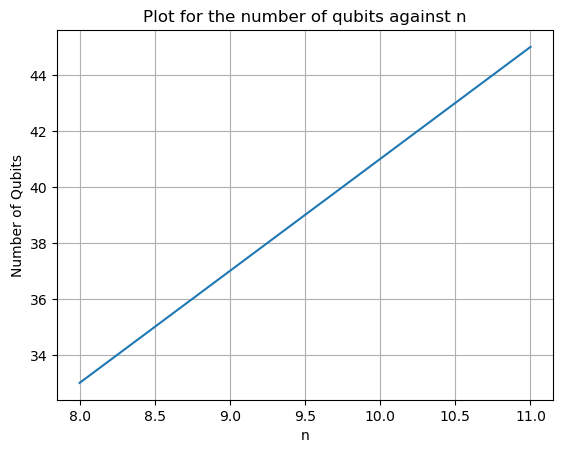

In [21]:
plt.plot(n, num_qubits)
plt.title("Plot for the number of qubits against n")
plt.xlabel("n")
plt.ylabel("Number of Qubits")
plt.grid()
plt.show()

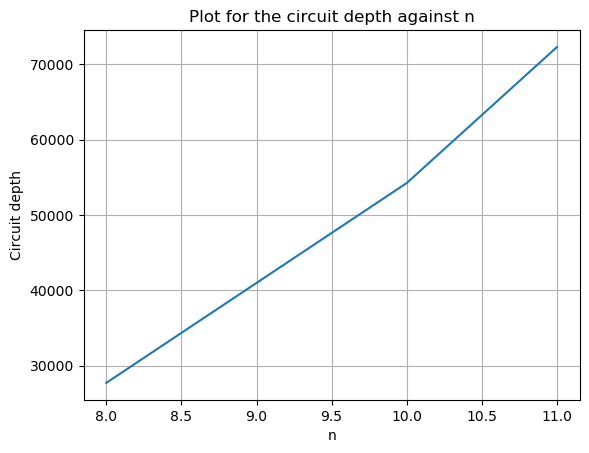

In [22]:
plt.plot(n,depths)
plt.title("Plot for the circuit depth against n")
plt.xlabel("n")
plt.ylabel("Circuit depth")
plt.grid()
plt.show()

In [23]:
def get_gates(num_gates):
    """
    Function to find number of gates from circuit information
    """
    
    cx_gates = []
    u3_gates = []
# measure_gates = []
    
    for this_dict in num_gates:
        cx_gates.append(this_dict['cx'])
        u3_gates.append(this_dict['u3'])
# measure_gates.append(this_dict['measure'])
        
# return cx_gates, u3_gates, measure_gates
    return cx_gates, u3_gates

# cx_gates, u3_gates, measure_gates = get_gates(num_gates)
cx_gates, u3_gates = get_gates(num_gates)

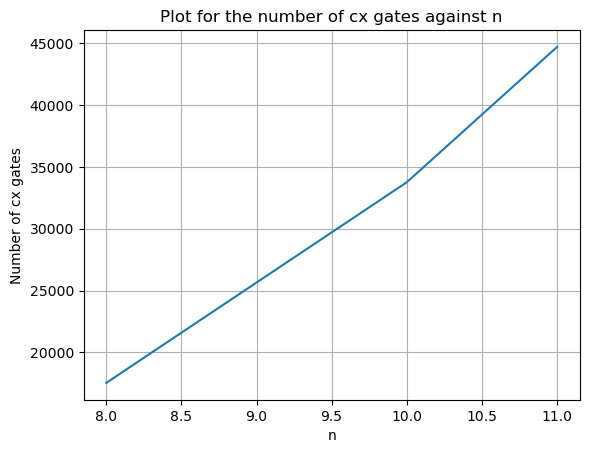

In [24]:
plt.plot(n, cx_gates)
plt.title("Plot for the number of cx gates against n")
plt.xlabel("n")
plt.ylabel("Number of cx gates")
plt.grid()
plt.show()

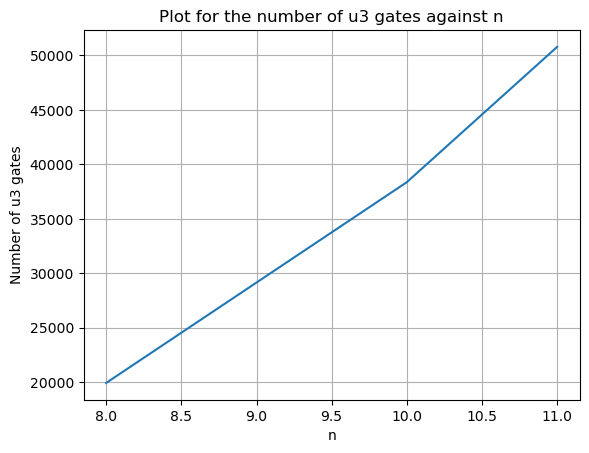

In [25]:
plt.plot(n, u3_gates)
plt.title("Plot for the number of u3 gates against n")
plt.xlabel("n")
plt.ylabel("Number of u3 gates")
plt.grid()
plt.show()